[Статейка](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

In [135]:
import copy
# ---------------------
import pandas as pd
import numpy as np
import seaborn as se

# Анализ

In [136]:
train_data, test_data = pd.read_csv("data/train.csv", delimiter=','), pd.read_csv("data/test.csv", delimiter=',')
train_data

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


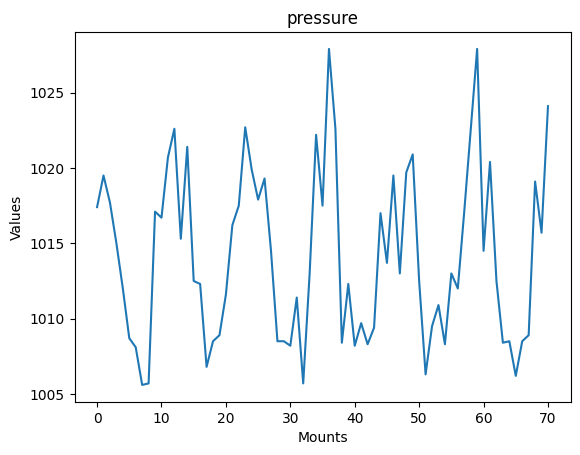

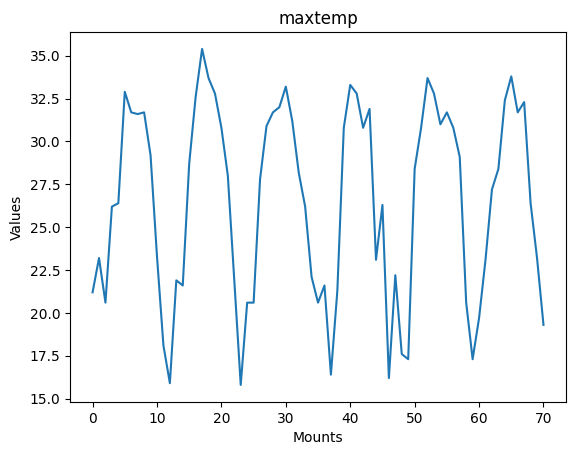

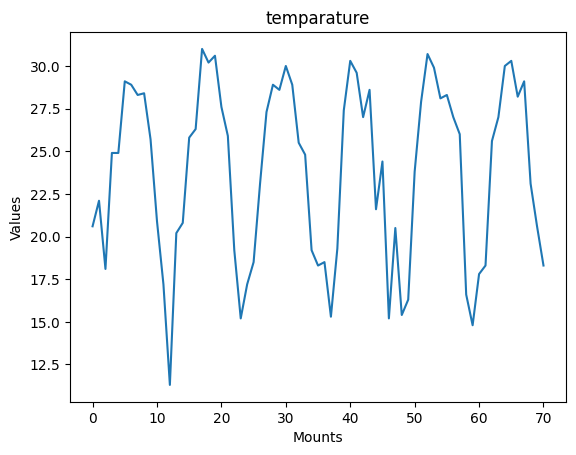

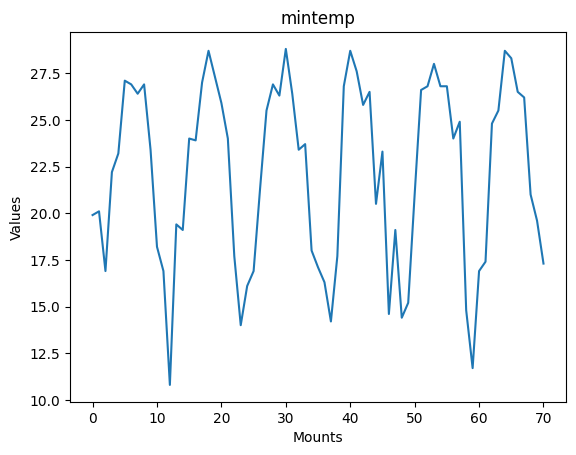

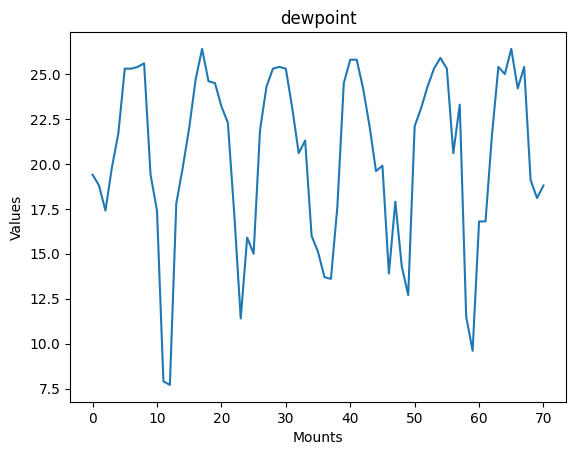

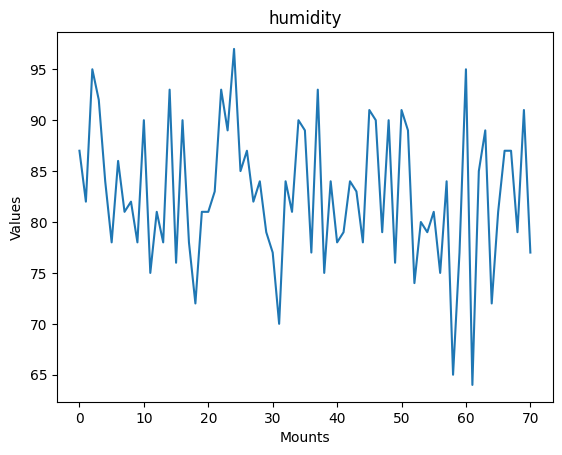

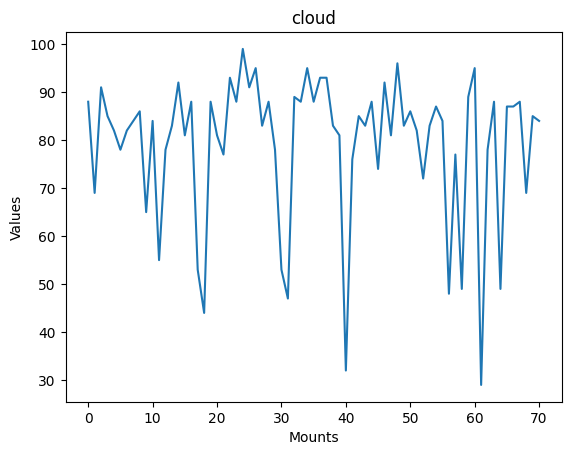

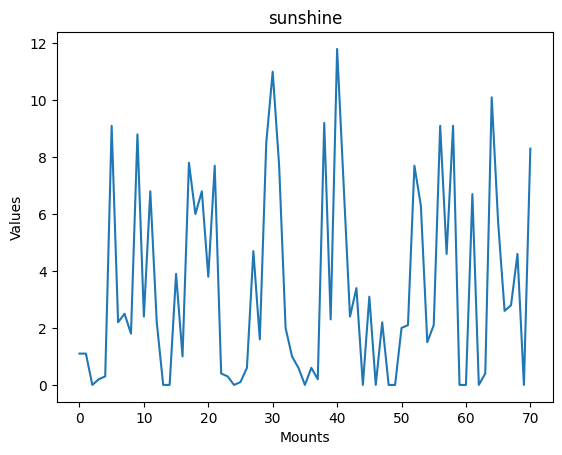

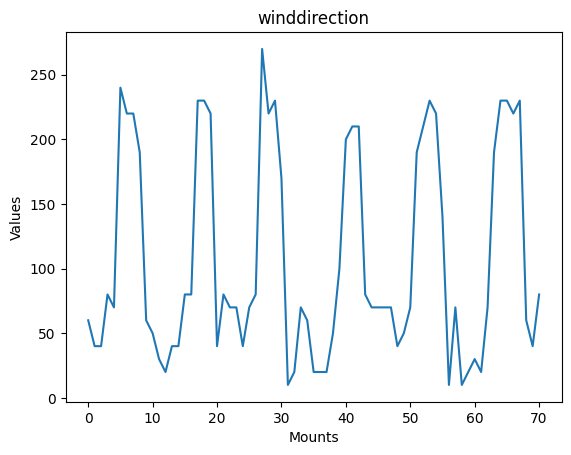

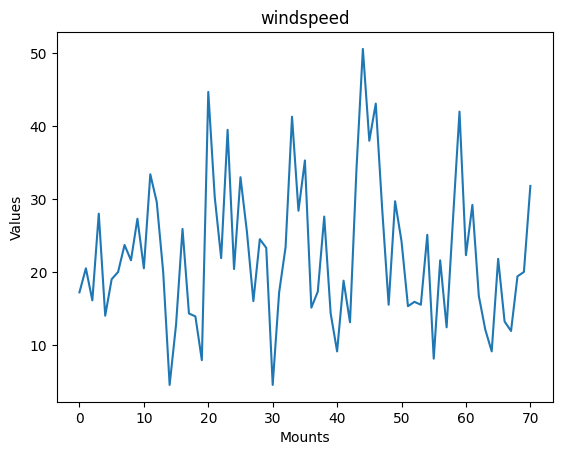

In [137]:
import matplotlib.pyplot as plt

for col in train_data.columns[2:-1]:
    pd.DataFrame(train_data[col].values[::31]).plot(title=col, legend=False, xlabel='Mounts', ylabel="Values")

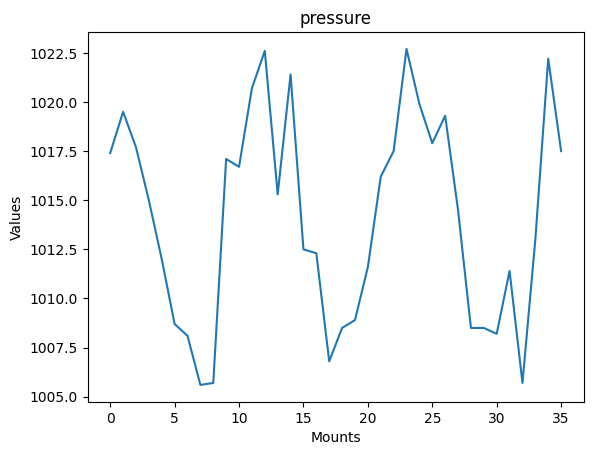

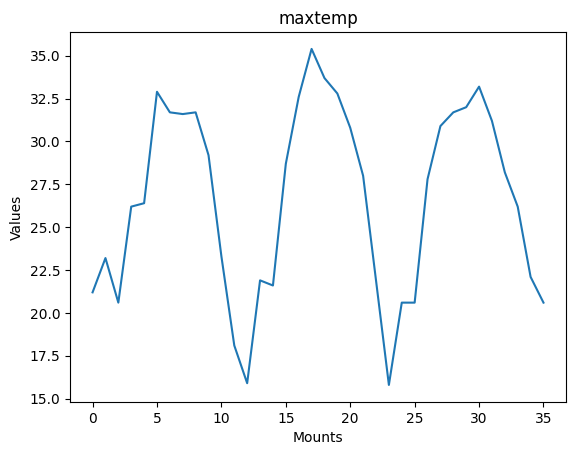

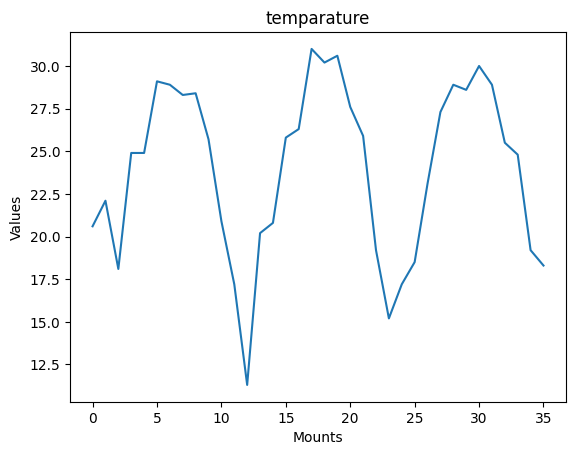

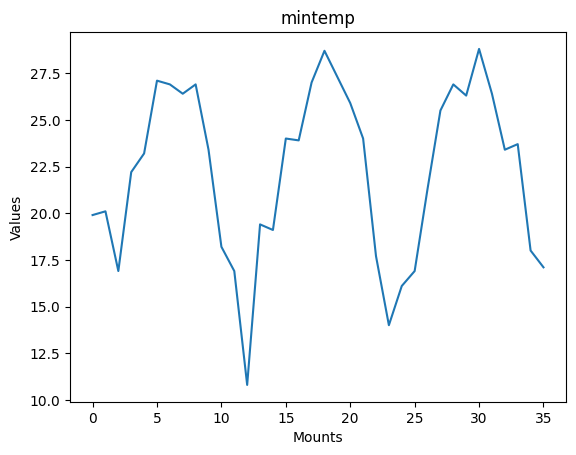

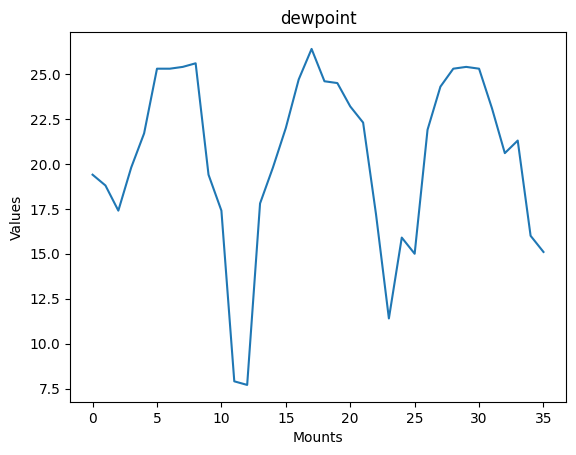

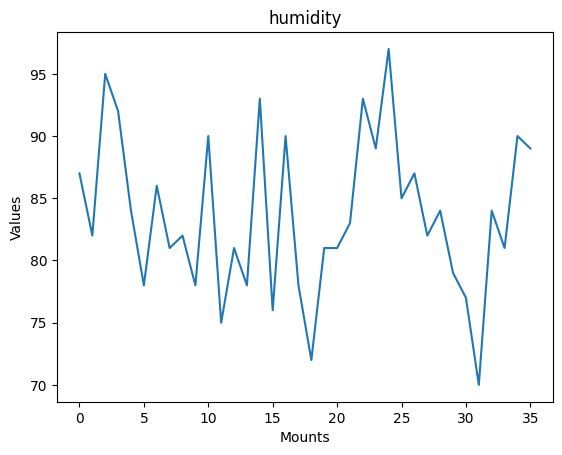

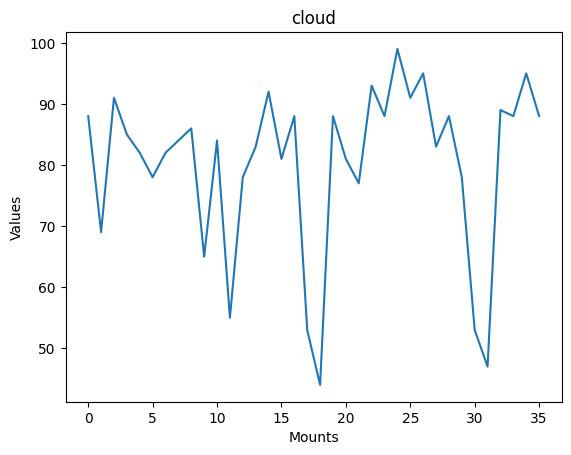

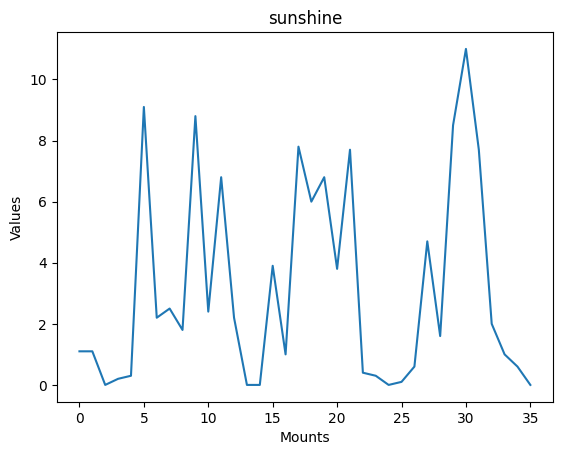

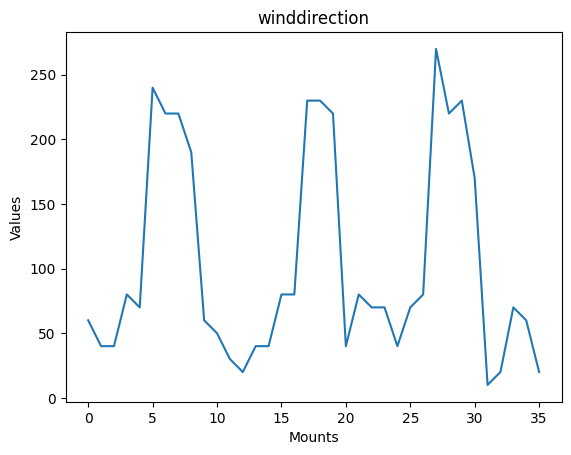

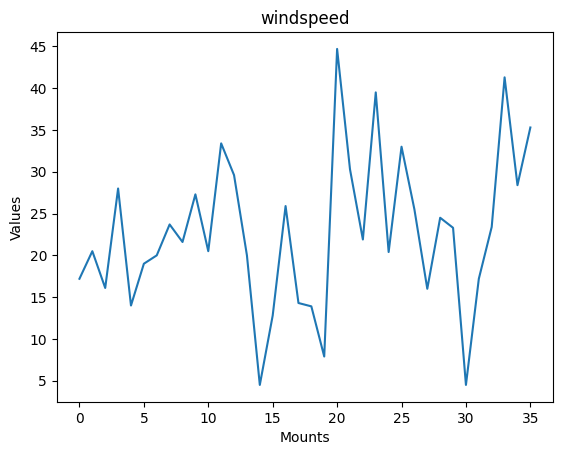

In [138]:
N = 31 # 91
YEAR = 365

for col in train_data.columns[2:-1]:
    pd.DataFrame(train_data[col].values[0:YEAR*3:N]).plot(title=col, legend=False, xlabel='Mounts', ylabel="Values")

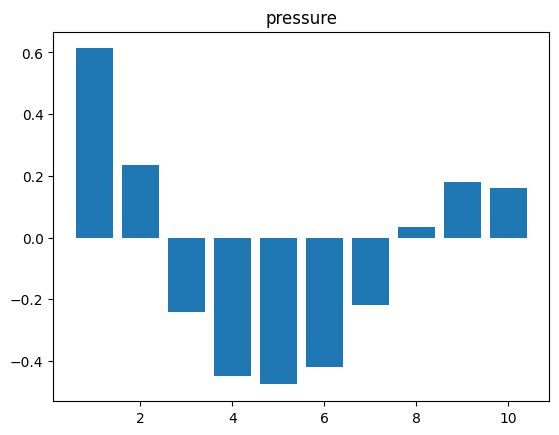

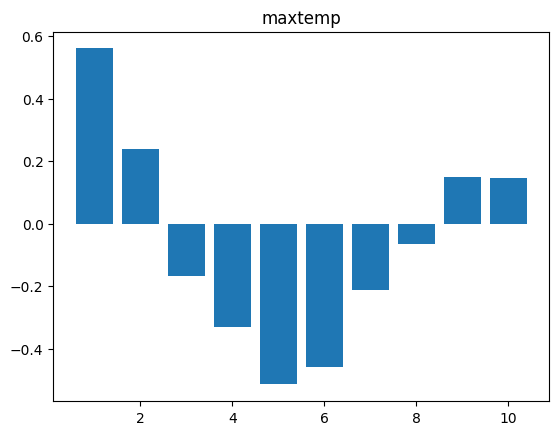

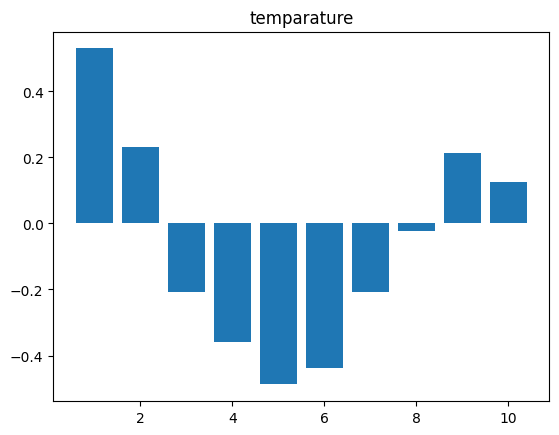

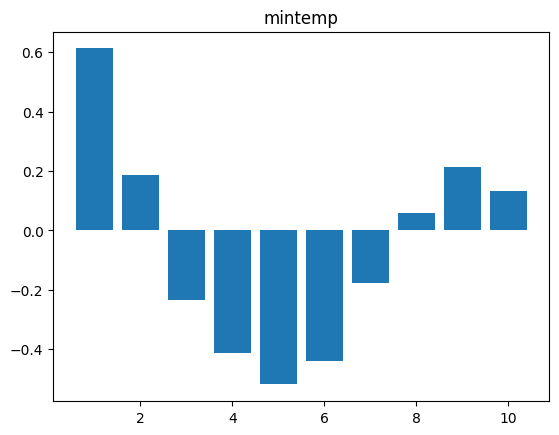

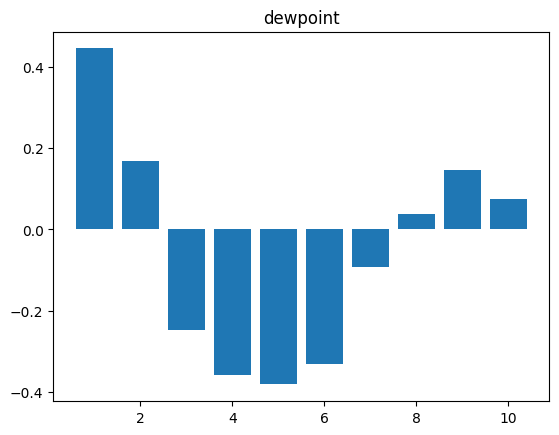

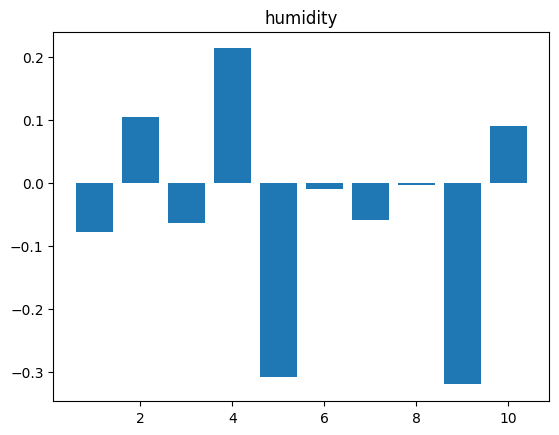

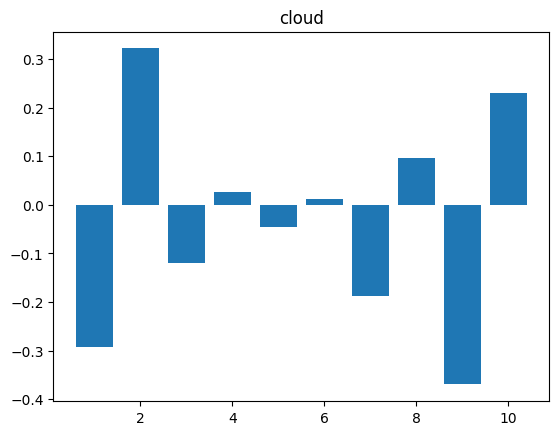

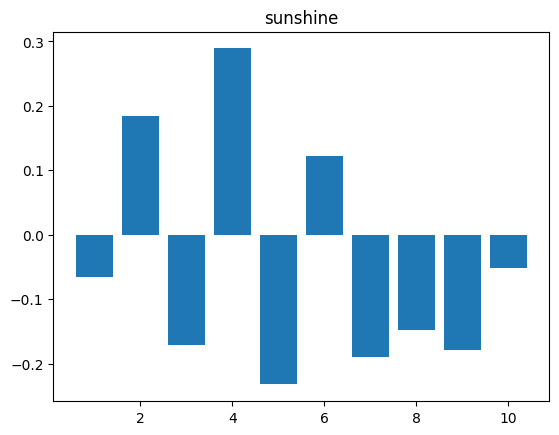

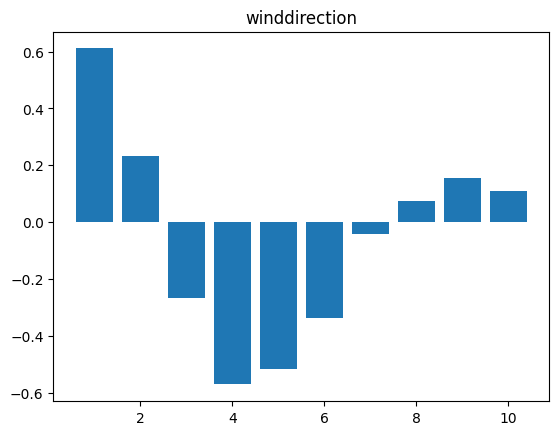

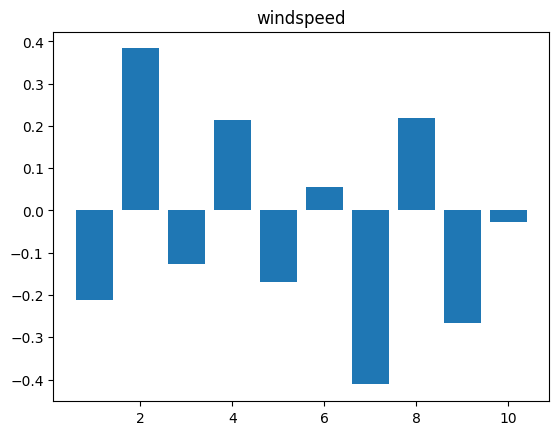

In [139]:
from statsmodels.tsa.stattools import acf

W = 4

def get_r(dataframe_list, lag):
    np_dataframe_list = np.array(dataframe_list)
    mean = np_dataframe_list.mean()
    # r = np.sum( (np_dataframe_list - mean) * ( np.concatenate([np_dataframe_list[:-lag], np.array([mean + 1] * lag)]) - mean) ) / np.sum( (np_dataframe_list - mean)**2 )
    r = np.sum( (np_dataframe_list - mean) * ( np_dataframe_list.shift(lag) - mean) ) / np.sum( (np_dataframe_list - mean)**2 )
    return r

r_col = {}
for col in train_data.columns[2:-1]:
    r_col[col] = acf(train_data[col].values[0:YEAR*1:N])
    # for i in range(1, W + 1):
        # r_col[col].append(get_r(train_data[col].values[0:YEAR*1:N], i))


for col in train_data.columns[2:-1]:
    plt.subplots(1, 1)
    plt.title(col)
    plt.bar(np.arange(1, len(r_col[col][1:]) + 1, 1), r_col[col][1:])

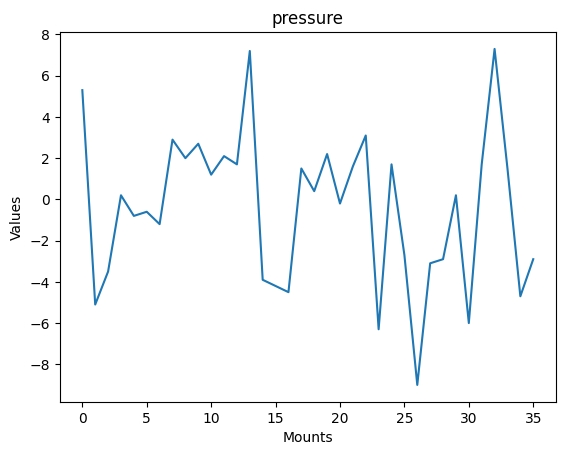

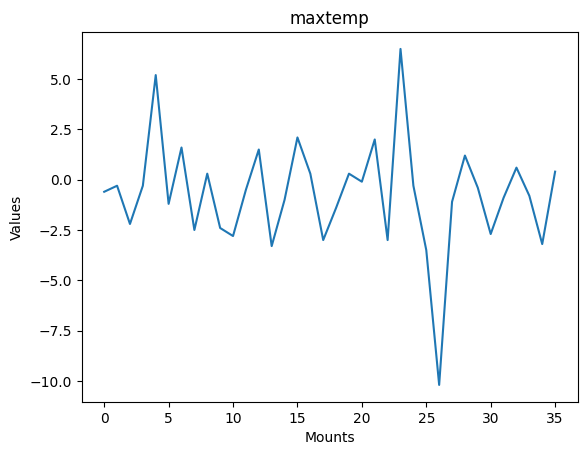

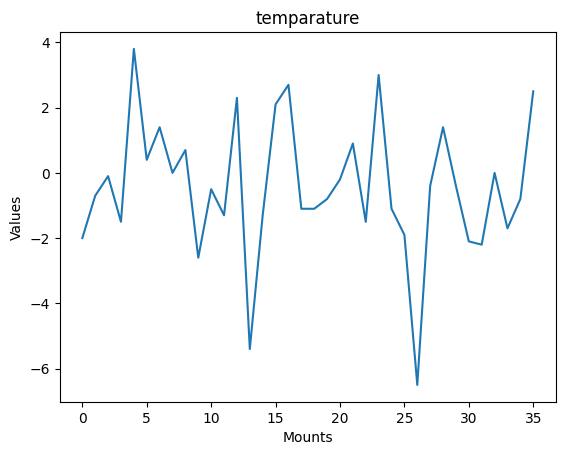

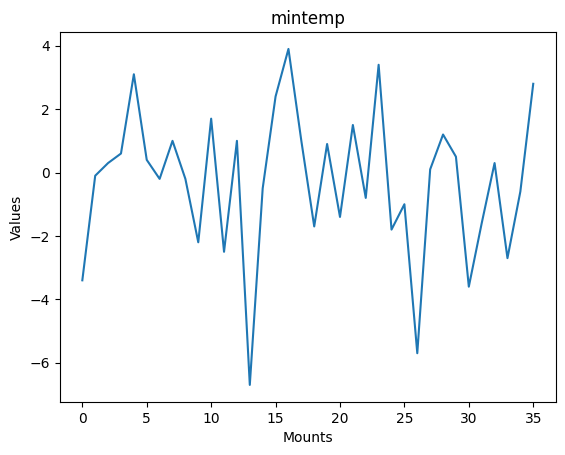

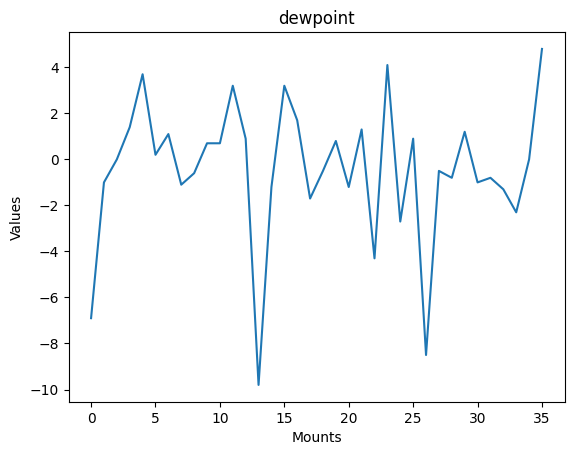

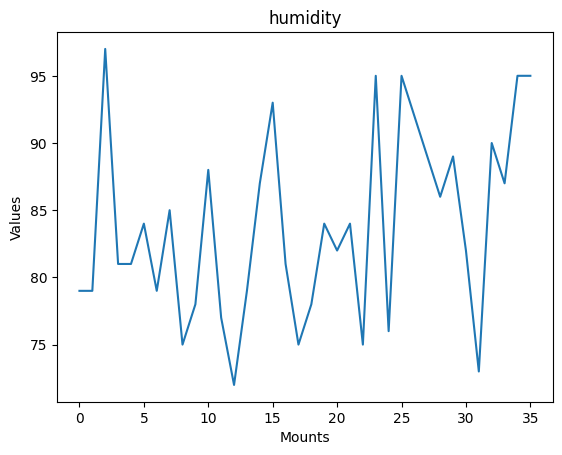

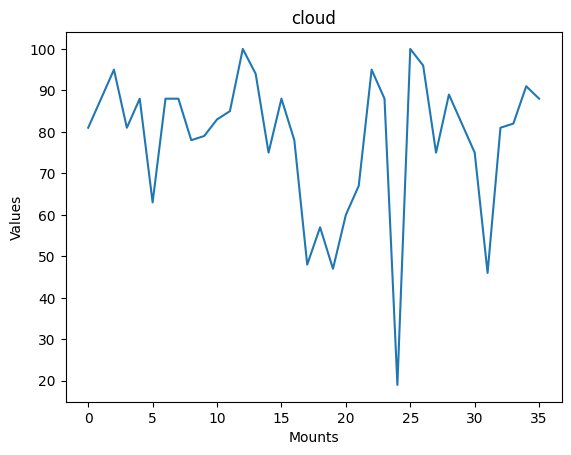

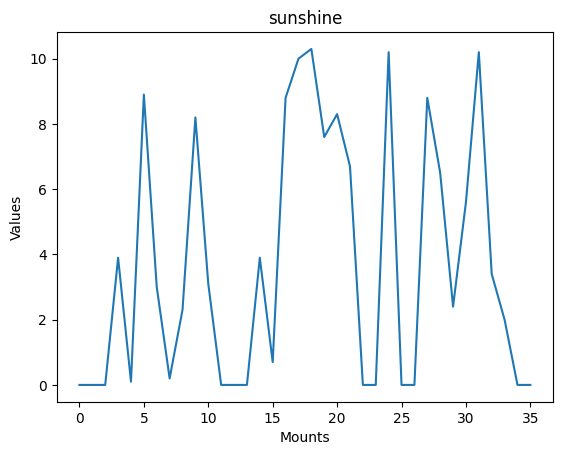

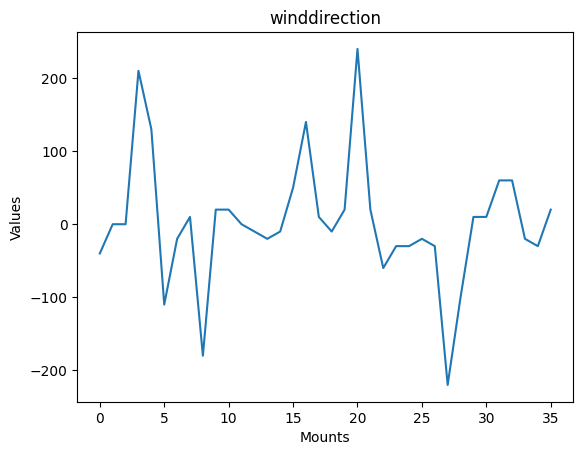

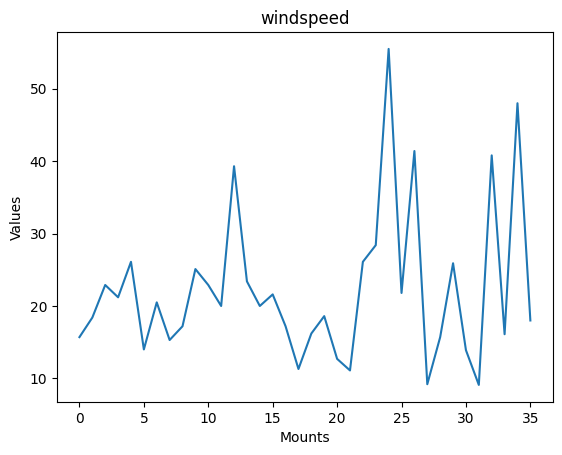

In [140]:
LAG = 5

train_data_copy = copy.copy(train_data)

train_data_copy["pressure"] = train_data_copy["pressure"].diff(LAG)
train_data_copy["maxtemp"] = train_data_copy["maxtemp"].diff(LAG)
train_data_copy["temparature"] = train_data_copy["temparature"].diff(LAG)
train_data_copy["mintemp"] = train_data_copy["mintemp"].diff(LAG)
train_data_copy["dewpoint"] = train_data_copy["dewpoint"].diff(LAG)
train_data_copy["winddirection"] = train_data_copy["winddirection"].diff(LAG)

train_data_copy.dropna(inplace=True)

for col in train_data_copy.columns[2:-1]:
    pd.DataFrame(train_data_copy[col].values[0:YEAR*3:N]).plot(title=col, legend=False, xlabel='Mounts', ylabel="Values")

In [141]:
from statsmodels.tsa.stattools import adfuller

for col in train_data_copy.columns[2:-1]:
    try:
        result = adfuller(train_data_copy[col].values[0:YEAR*3:N])
        print(f"ADF Stat: {result[0]}, p-val: {result[1]}")
    except:
        print(":(")

ADF Stat: -5.181132954255781, p-val: 9.606295376362171e-06
ADF Stat: -4.6607282037057445, p-val: 9.967157444541616e-05
ADF Stat: -4.48917933324925, p-val: 0.00020568473537183082
ADF Stat: -3.8573531401605234, p-val: 0.0023721128729166387
ADF Stat: -5.023573210133865, p-val: 1.992857161981176e-05
ADF Stat: -5.174518144085031, p-val: 9.908681078352598e-06
ADF Stat: -5.100692311522598, p-val: 1.3974127959192398e-05
ADF Stat: -3.3202606996858814, p-val: 0.013996757451876523
ADF Stat: -4.556237763319066, p-val: 0.00015540944488910065
ADF Stat: -3.4000537191732203, p-val: 0.010957040461935774


In [142]:
train_data = train_data_copy

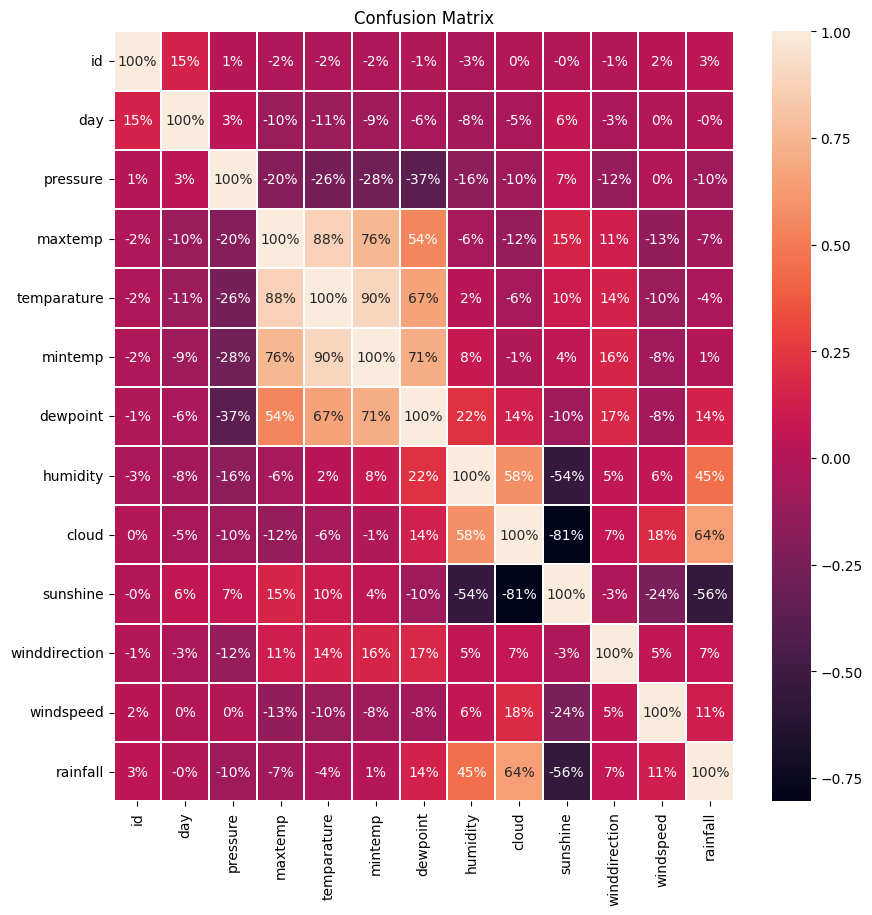

In [143]:
def draw_cov(data):
    figsize = (10,10)
    fig, ax = plt.subplots(figsize=figsize)
    plt.title('Confusion Matrix')
    se.heatmap(data.corr(), annot=True, fmt="0.0%", linewidth=0.1)

draw_cov(train_data)

# Построение модели

In [187]:
from sklearn.model_selection import train_test_split

X, y = train_data_copy[train_data_copy.columns[2:-1]].values, train_data_copy[train_data_copy.columns[-1]].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [188]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5_000).fit(X_train, y_train)
model.score(X_test, y_test)

0.8718535469107551

In [189]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)

In [190]:
scores.mean(), scores.std()

(np.float64(0.8599542334096111), np.float64(0.010172133075923476))